In [ ]:
from multiprocessing import Pool

HEIGHT = None
WIDTH = None

Datorită cnstrângerii de memorie vom reține doar celulele vii. Pentru eficiență reprezentăm matricea printr-un set unidimensional, fiecare celulă fiind definită de formula x * WIDTH + y.

In [ ]:
def compressed_cell(cell):
  x, y = cell
  return x * WIDTH + y

def decompressed_cell(compressed_cell):
  x = compressed_cell // WIDTH
  y = compressed_cell % WIDTH
  return x, y

In [ ]:
#Funcție ce returnează vecinii unui celule.
def get_neighbours(cell):
  x, y = decompressed_cell(cell)
  neighbours = [
      (x - 1, y),
      (x + 1, y),
      (x, y - 1),
      (x, y + 1),
      (x - 1, y - 1),
      (x - 1, y + 1),
      (x + 1, y - 1),
      (x + 1, y + 1)
  ]
  return [
      compressed_cell(neighbour)
      for neighbour in neighbours
      if neighbour[0] in range(0, WIDTH) and neighbour[1] in range(0, HEIGHT)
  ]

Am reușit să rulez un ciclu Conway până la 10 milioane de celule active, în timp de 10 minute

In [ ]:
def cicle(live_cells):
  cells_to_visit = set()
  new_state = set()

  #Vizităm celule vii și vecinii acestora
  for cell in live_cells:
    cells_to_visit.add(cell)
    neighbours = get_neighbours(cell)
    cells_to_visit.update(neighbours)

  for cell in cells_to_visit:
    neighbours = get_neighbours(cell)
    live_neighbours = [
        neighbour
        for neighbour in neighbours
        if neighbour in live_cells
    ]
    num_live_neighbours = len(live_neighbours)

    '''
    Dacă celula vie are mai puțin de 2 sau mai multi de 3 vecini vii moare.
    Dacă orice celula are exact 3 vecini vii devine vie.
    Dacă are 2 vecini vii și este vie, ramane vie.
    '''
    if (num_live_neighbours == 2 and cell in live_cells) or num_live_neighbours == 3:
      new_state.add(cell)

  return new_state

def conway(live_cells, number_of_cicles, draw=True):
  for _ in range(number_of_cicles):
    live_cells = cicle(live_cells)
    if draw:
      plot(live_cells)
  return live_cells

In [ ]:
import matplotlib.pyplot as plt

def plot(live_cells):
  plt.clf()
  X = [decompressed_cell(cell)[0] for cell in live_cells]
  Y = [decompressed_cell(cell)[1] for cell in live_cells]
  plt.scatter(X, Y)

  plt.pause(0.001)

De asemenea am inplementat algoritmul cu paralelism, dar memoria RAM consumată s-a dublat, fără un câștig la capitolul perfoermanță.


In [ ]:
def process_cells(block, live_cells):
    """
    Procesează un subset de celule și determină noua stare.
    """
    new_state = set()
    for cell in block:
        neighbours = get_neighbours(cell)
        live_neighbours = [
            neighbour
            for neighbour in neighbours
            if neighbour in live_cells
        ]
        num_live_neighbours = len(live_neighbours)

        if (num_live_neighbours == 2 and cell in live_cells) or num_live_neighbours == 3:
            new_state.add(cell)
    return new_state

def cicle_parallel(live_cells, num_processes=2):
    """
    Paralelizează procesarea ciclului Game of Life.
    """
    cells_to_visit = set()

    # Calculăm toate celulele care trebuie vizitate
    for cell in live_cells:
        cells_to_visit.add(cell)
        neighbours = get_neighbours(cell)
        cells_to_visit.update(neighbours)

    # Împărțim cells_to_visit în blocuri
    cells_to_visit = list(cells_to_visit)
    chunk_size = len(cells_to_visit) // num_processes
    blocks = [
        cells_to_visit[i * chunk_size: (i + 1) * chunk_size]
        for i in range(num_processes)
    ]

    # Adăugăm restul celulelor în ultimul bloc, dacă există
    if len(cells_to_visit) % num_processes != 0:
        blocks[-1].extend(cells_to_visit[num_processes * chunk_size:])

    # Folosim multiprocessing pentru a procesa blocurile în paralel
    with Pool(num_processes) as pool:
        results = pool.starmap(process_cells, [(block, live_cells) for block in blocks])

    # Combinăm rezultatele într-un set unic
    new_state = set().union(*results)
    return new_state

def conway_parallel(live_cells, number_of_cicles, draw=False):
    """
    Paralelizează executia Game of Life.
    """
    for _ in range(number_of_cicles):
        live_cells = cicle_parallel(live_cells)
        if draw:
            plot(live_cells)
    return live_cells


Grid-ul inițial poate fi citit dintr-un fișier YAML sau poate fi generat aleatoriu.

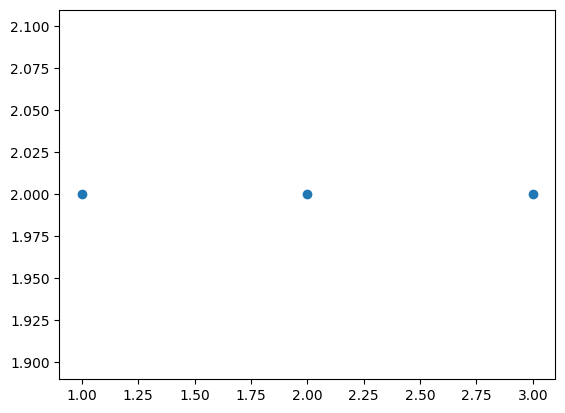

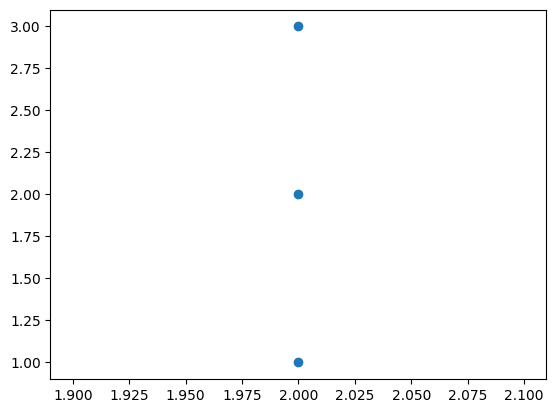

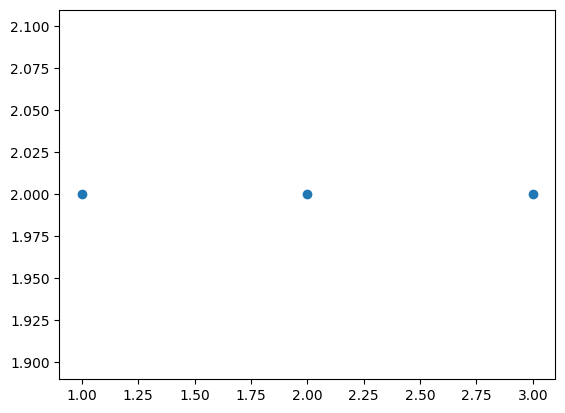

{12, 22, 32}

In [ ]:
import yaml

with open('/content/grid.yaml', 'r') as f:
  grid = yaml.safe_load(f)

WIDTH = grid['width']
HEIGHT = grid['height']
number_of_cicles = grid['number_of_cicles']
live_cells = set(compressed_cell(tuple(cell)) for cell in grid['live_cells'])

plot(live_cells)
conway(live_cells, 2)

In [ ]:
from random import sample

def get_random_grid(width, height, num_live_cells):
  total_cells = width * height
  live_cells = set(sample(range(total_cells), num_live_cells))
  return live_cells

In [ ]:
#Testăm algoritmul pt o 100.000 de celule vii.
WIDTH = 1000
HEIGHT = 1000
num_live_cells = 100_000
live_cells = get_random_grid(WIDTH, HEIGHT, num_live_cells)
len(live_cells)

100000

In [ ]:
len(conway_parallel(live_cells, 3, False))

35577

In [ ]:
len(conway(live_cells, 3, False))

35577

In [ ]:
#Testăm algoritmul pt 10 milioane de celule vii.
WIDTH = 10_000
HEIGHT = 10_000
num_live_cells = 10_000_000
live_cells = get_random_grid(WIDTH, HEIGHT, num_live_cells)

In [ ]:
len(live_cells)

10000000

In [ ]:
result = conway(live_cells, 1, False)
result

{50331649,
 8388612,
 8388613,
 25165830,
 25165831,
 50331656,
 9,
 50331657,
 92274692,
 83886093,
 67108881,
 16777234,
 67108882,
 67108883,
 67108886,
 8388631,
 8388632,
 67108887,
 58720285,
 75497502,
 41943076,
 92274724,
 92274725,
 83886121,
 33554476,
 41943087,
 83886127,
 50331697,
 50331698,
 8388659,
 83886128,
 83886129,
 58720313,
 58720314,
 41943099,
 33554492,
 41943101,
 83886138,
 8388675,
 8388677,
 16777286,
 16777287,
 50331720,
 50331721,
 75497544,
 50331723,
 75497545,
 83886154,
 93368869,
 67108948,
 8388693,
 8388694,
 58720343,
 67108949,
 41943129,
 92274774,
 92274775,
 75497565,
 25165918,
 25165919,
 16777312,
 58720351,
 100,
 67108964,
 75497577,
 16777333,
 16777335,
 16777336,
 83886205,
 67108990,
 41943167,
 41943169,
 133,
 134,
 135,
 16777356,
 16777357,
 16777358,
 50331790,
 50331789,
 67109007,
 75497619,
 75497620,
 75497621,
 75497622,
 92274837,
 16777369,
 8388762,
 8388763,
 16777371,
 33554587,
 33554589,
 41943194,
 58720411,
 671

In [ ]:
result = conway_parallel(live_cells, 1, False)
result

{50331649,
 8388612,
 8388613,
 25165830,
 25165831,
 50331656,
 9,
 50331657,
 92274692,
 83886093,
 67108881,
 16777234,
 67108882,
 67108883,
 67108886,
 8388631,
 8388632,
 67108887,
 58720285,
 75497502,
 41943076,
 92274724,
 92274725,
 83886121,
 33554476,
 41943087,
 83886127,
 50331697,
 50331698,
 8388659,
 83886128,
 83886129,
 76695854,
 58720313,
 58720314,
 41943099,
 33554492,
 41943101,
 83886138,
 8388675,
 8388677,
 16777286,
 16777287,
 50331720,
 50331721,
 75497544,
 50331723,
 75497545,
 83886154,
 67108948,
 8388693,
 8388694,
 67108949,
 58720343,
 41943129,
 92274774,
 92274775,
 75497565,
 25165918,
 25165919,
 16777312,
 58720351,
 100,
 67108964,
 75497577,
 16777333,
 16777335,
 16777336,
 83886205,
 67108990,
 41943167,
 41943169,
 133,
 134,
 135,
 16777356,
 16777357,
 16777358,
 50331789,
 50331790,
 67109007,
 75497619,
 75497620,
 75497621,
 75497622,
 92274837,
 16777369,
 8388762,
 8388763,
 16777371,
 41943194,
 33554587,
 33554589,
 58720411,
 671